In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import NotFittedError
from sklearn.base import BaseEstimator

## Создание данных

Text(0, 0.5, '$feature_2$')

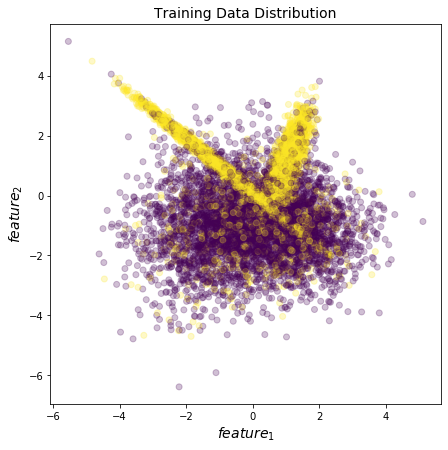

In [2]:
data, target = make_classification(
    n_samples=10000,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=2,
    random_state=27,
    flip_y=0.25
)

fig = plt.figure(figsize=(7, 7))
plt.title("Training Data Distribution", size=14)
plt.scatter(data[:, 0], data[:, 1], c=target, cmap="viridis", alpha=0.25)
plt.xlabel("$feature_1$", size=14)
plt.ylabel("$feature_2$", size=14)

In [3]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, shuffle=True, random_state=27
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, shuffle=True, random_state=27
)

In [4]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

## Реализация дерева решений

In [5]:
class DecisionTreeClassifier:
    """
    Реализация классификатора на основе решающего дерева.

    Parameters
    ----------
    max_depth: int, optional, default = 6
        Максимальная глубина дерева. Если значение не указано,
        то дерево строится без ограничения глубины. Опциональный
        параметр, по умолчанию, равен 6.

    num_leaves: int, optional, default = 64
        Максимальное количество листьев дерева. Если значение не
        указано, то дерево строится без ограничения количества листьев.
        Опциональный параметр, по умолчанию, равен 64.

    min_samples_leaf: int, optional, default = 5
        Минимальное количество объектов в листе, необходимое для
        проведения разбиения. Опциональный параметр, по умолчанию,
        равен 5.

    criterion: str, {"gini", "entropy"}, default = "gini"
        Критерий информативности для поиска оптимального сплита.
        Опциональный параметр, по умолчанию, используется индекс Джини.

    """
    def __init__(
        self,
        max_depth: int = 6,
        num_leaves: int = 64,
        min_samples_leaf: int = 5,
        criterion: str = "gini"):

        self.max_depth = max_depth
        self.num_leaves = num_leaves
        self.min_samples_leaf = min_samples_leaf

        if criterion not in ["gini", "entropy"]:
            raise ValueError(
                "Incorrect criterion value. Please use: 'gini' or 'entropy'."
            )

        self.information_criterio = self.calculate_gini if criterion == "gini" else self.calculate_entropy
        self.current_leaves = 0
        self.current_depth = 0
        self.tree = None

    def fit(self, X: np.array, y: np.array):
        """
        Обучение решающего дерева.

        Parameters
        ----------
        X: np.array, shape = [n_samples, n_features]
            Матрица признаков для обучения модели.

        y: np.array, shape = [n_samples, ]
            Вектор целевой переменной для обучения модели.

        Returns
        -------
        self

        """
        self.tree = self.build_tree(X, y)
        return self

    def predict(self, X: np.array):
        """
        Применение обученной модели для построения прогнозов.
        Если модель не была обучена, то возбуждается ошибка типа
        NotFittedError.

        Parameters
        ----------
        X: np.array, shape = [n_samples, n_features]
            Матрица признаков для применения модели.

        Returns
        -------
        y_pred: List[int]
            Список предсказанных значений.

        """
        if not self.tree:
            raise NotFittedError(
                "This DecisionTreeClassifier instance is not fitted yet. "
                "Call 'fit' with appropriate arguments before using this estimator."
            )

        y_pred = []
        for x in X:
            prediction = self.classify_object(x, self.tree)
            y_pred.append(prediction)
        return y_pred

    @staticmethod
    def calculate_gini(y_pred: np.array) -> float:
        """
        Вычисление критерия информативности "индекс Джини".

        Parameters
        ----------
        y_pred: np.array, shape = [n_samples, ]
            Вектор прогнозов.

        Returns
        -------
        score: float
            Значение индекса Джини.

        """
        classes = {}
        for label in y_pred:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        score = 1
        for label in classes:
            p = classes[label] / len(y_pred)
            score -= p**2

        return score

    @staticmethod
    def calculate_entropy(y_pred: np.array) -> float:
        """
        Вычисление критерия информативности "Энтропия Шеннона".

        Parameters
        ----------
        y_pred: np.array, shape = [n_samples, ]
            Вектор прогнозов.

        Returns
        -------
        score: float
            Значение энтропии.

        """
        classes = {}
        for label in y_pred:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        score = 0
        for label in classes:
            p = classes[label] / len(y_pred)
            score += p*np.log2(p)

        return -score

    def quality(self, left_labels, right_labels, current_gini):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        right_p = self.information_criterio(right_labels)
        left_p = self.information_criterio(left_labels)

        return current_gini - p*left_p - (1 - p)*right_p

    def split(self, data, labels, index, t):
    
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, X, y):
    
        #  обозначим минимальное количество объектов в узле
        current_quality = self.information_criterio(y)

        best_quality = 0
        best_t = None
        best_index = None
        n_features = X.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in X])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(X, y, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_quality)
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, X, y):

        quality, t, index = self.find_best_split(X, y)
        #  Базовый случай - прекращаем рекурсию, когда достигнут предел по кол-ву листьев
        if self.current_leaves <= self.num_leaves:
            return Leaf(X, y)

        # Случай 2 - прекращаем рекурсию, когда достигнут предел по глубине дерева
        if self.current_depth <= self.max_depth:
            return Leaf(X, y)

        # Случай 3 - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(X, y)

        true_data, false_data, true_labels, false_labels = self.split(X, y, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        self.current_depth += 1
        self.num_leaves += 2
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

In [6]:
%%time
tree = DecisionTreeClassifier(max_depth=3, num_leaves=8)
tree.fit(x_train, y_train)

CPU times: user 43.3 s, sys: 324 ms, total: 43.7 s
Wall time: 44.5 s


In [7]:
y_pred = tree.predict(x_valid)